In [1]:
from PIL import Image, ImageTk
from tkinter import *
from tkinter import ttk
from tkinter import filedialog
import tksheet
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.stats import mode

In [2]:
class Prototype(Tk):
    def __init__(self):
        super(Prototype, self).__init__()
        self.initUI()
        self.createWidgets()
    
    def initUI(self):
        self.title("Prototype")
        self.geometry('1920x1080')
        self.wm_iconbitmap('icon.ico')
        
    def createWidgets(self):
        self.toolBar()
        self.tabs()
        self.sheets()
    

    def toolBar(self):
        self.toolbar = Frame(self, bd=1, relief=RAISED)
        self.img = Image.open("/png/24/Modern3D/objects/exit.png")
        eimg = ImageTk.PhotoImage(self.img)
        exitButton = Button(toolbar, image=eimg, relief=FLAT,command=self.quit)
        exitButton.image = eimg
        exitButton.pack(side=LEFT, padx=2, pady=2)
        toolbar.pack(side=TOP, fill=X)
        #self.config(menu=menubar)
        self.pack()

    def onExit(self):
        self.quit()

    def sheets(self):
        self.sheet = tksheet.Sheet(self.tab1,
                                   page_up_down_select_row = True,
                                   #empty_vertical = 0,
                                   column_width = 120,
                                   startup_select = (0,1,"rows"),
                                   #row_height = "4",
                                   #default_row_index = "numbers",
                                   #default_header = "both",
                                   #empty_horizontal = 0,
                                   #show_vertical_grid = False,
                                   #show_horizontal_grid = False,
                                   #auto_resize_default_row_index = False,
                                   #header_height = "3",
                                   #row_index_width = 100,
                                   #align = "e",
                                   #header_align = "w",
                                   #row_index_align = "w",
                                   #data = [[f"Row {r}, Column {c}\nnewline1\nnewline2" for c in range(50)] for r in range(1000)], #to set sheet data at startup
                                   #headers = [f"Column {c}\nnewline1\nnewline2" for c in range(30)],
                                   #row_index = [f"Row {r}\nnewline1\nnewline2" for r in range(2000)],
                                   #set_all_heights_and_widths = True, #to fit all cell sizes to text at start up
                                   #headers = 0, #to set headers as first row at startup
                                   #headers = [f"Column {c}\nnewline1\nnewline2" for c in range(30)],
                                   #theme = "light green",
                                   #row_index = 0, #to set row_index as first column at startup
                                   #total_rows = 2000, #if you want to set empty sheet dimensions at startup
                                   #total_columns = 30, #if you want to set empty sheet dimensions at startup
                                   height = 500, #height and width arguments are optional
                                   width = 1200 #For full startup arguments see DOCUMENTATION.md
                                  )
        self.sheet.grid()
        # table enable choices listed below:
        self.sheet.enable_bindings(("single_select","row_select","column_width_resize",
                               "arrowkeys","right_click_popup_menu","rc_select","rc_insert_row",
                               "rc_delete_row","copy","cut","paste","delete","undo","edit_cell"))
    
    def quit_btn(self):
        button = ttk.Button(self, text="Quit", command=self.destroy)
        button.pack()
    
    def display_figure(self, fig):
        canvas = FigureCanvasTkAgg(fig, master=self.tab2)  # A tk.DrawingArea.
        canvas.draw()
        canvas.get_tk_widget().grid(row=0, column=0)
    
    def tabs(self):
        self.tabControl = ttk.Notebook(self)
        self.tab1 = ttk.Frame(self.tabControl)
        self.tabControl.add(self.tab1, text='Initialize')
        self.tab2 = ttk.Frame(self.tabControl)
        self.tabControl.add(self.tab2, text='Clean Up')
        self.tabControl.pack(expand=1, fill="both")
        ttk.Label(self.tab1, text="Initialize").grid(column=0, row=0, padx=10, pady=10)
        ttk.Label(self.tab2, text="Clean Up").grid(column=0, row=0, padx=10, pady=10)

In [3]:
def init():
    # set pd options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

In [4]:
def loadData(file_name, parse_dates= None):
    # load the three data sets 
    if parse_dates:
        return pd.read_csv(file_name, parse_dates=parse_dates)
    else:
        return pd.read_csv(file_name)

In [5]:
# create a function to extract and clean up PED 
def extractPED(df):
    df['PE DESCRIPTION'] = df['PE DESCRIPTION'].str.strip()
    ped = df["PE DESCRIPTION"].str.extract("\((.*?)\)").set_axis(['PED'], axis = 1)
    ped["PED"] = ped["PED"].replace({'SQ. FT.': 'SF'}, regex=True)
    ped["PED"].replace({"\d{1,3}(?=(\d{3})+(?!\d))":"\g<0>,"}, regex=True, inplace = True)
    ped[ped["PED"].str.match(".*\,\d{3}\s\+")==True] += " SF"
    return ped

In [6]:
def cleanUpInspectionData(df):
    # find the INACTIVE
    index = df[(df['PROGRAM STATUS']=="INACTIVE")].index
    # drop the rows
    df.drop(index , inplace=True)   
    # extract and clean up PED for two instances
    df['PED'] = extractPED(df)
    # clean up Zip code from +4 as we are interested in the area and not specific address
    df['FACILITY ZIP'] = df['FACILITY ZIP'].str[:5]
    # check for any bad ZIP containing letters
    df["FACILITY ZIP"].replace({"\w*[a-zA-Z]\w*":"99999"}, regex=True, inplace = True)
    # drop the rows that contain a null zip
    index = insp[df['FACILITY ZIP'].isnull()].index
    df.drop(index , inplace=True)  
    # change to numeric value 
    df["FACILITY ZIP"] = df["FACILITY ZIP"].str[:5].astype(int)
    
def cleanUpInventoryData(df):
    df['PED'] = extractPED(df)

In [7]:
insp = loadData("Inspections.csv", parse_dates=['ACTIVITY DATE'])
viol = loadData("violations.csv")
invt = loadData("Inventroy.csv")

cleanUpInspectionData(insp)
cleanUpInventoryData(invt)


In [8]:
# insp.head(10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 <a list of 96 Text major ticklabel objects>)

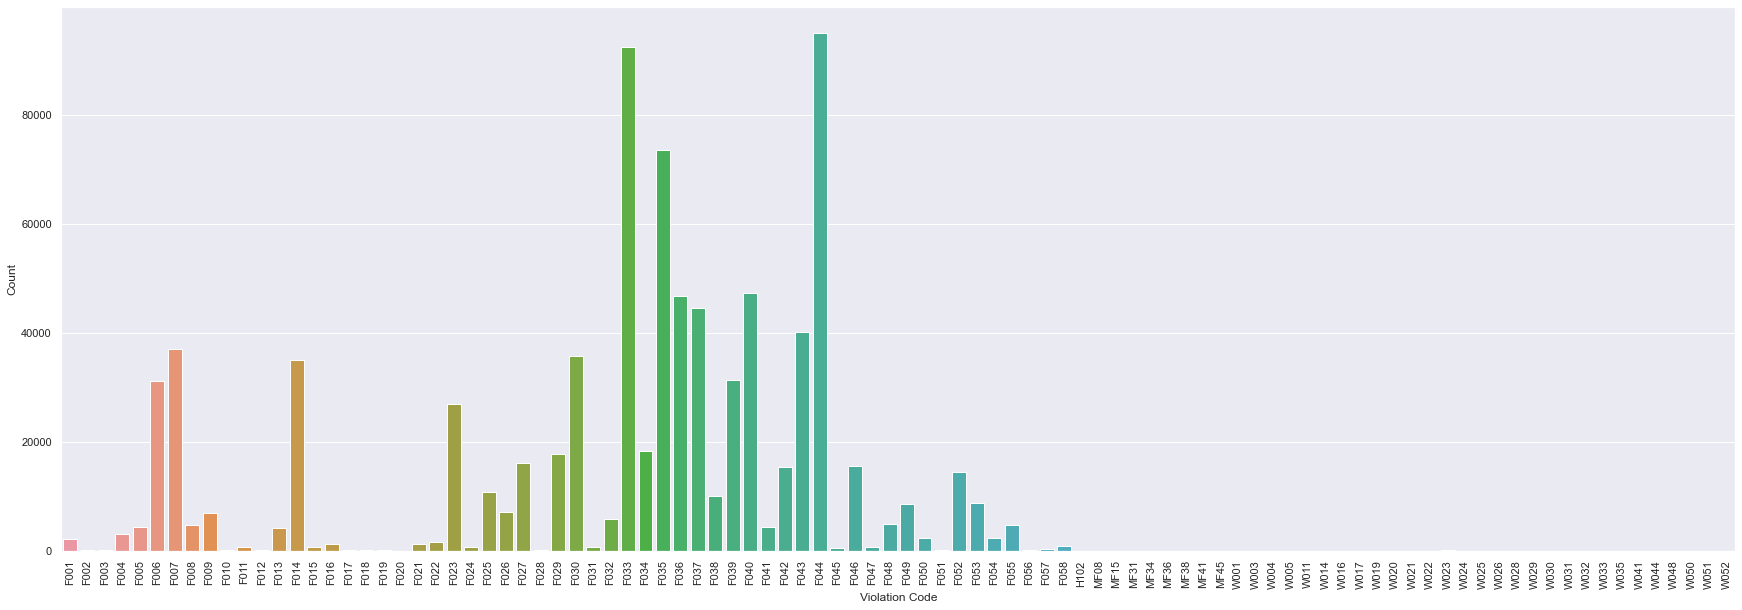

In [9]:
# Produce a suitable graph that displays the number of establishments that have committed each type of violation, you may need to consider how you group this data to make visualisation feasible. 
left = insp[['FACILITY ID','FACILITY NAME','SERIAL NUMBER','FACILITY ZIP']]
right = viol[['SERIAL NUMBER','VIOLATION CODE']]
join = pd.merge(left, right, on='SERIAL NUMBER', how='left')
# setup the plot data
plot_data = pd.DataFrame()
plot_data[['Violation Code','Count']] = join.groupby(["VIOLATION CODE"])["FACILITY ID"].count().reset_index()
# setup and generate the graph
sb.set(style="darkgrid")    
fig, ax = plt.subplots(figsize=(30, 10))  
g = sb.barplot(ax=ax, x="Violation Code", y="Count", data=plot_data)
#color=cmap(norm(plot_data.Count.values))
plt.xticks(rotation=90)
#plt.show()

In [10]:
app = Prototype()
app.sheet.headers((f"{c}" for c in insp.columns.values)) #any iterable works
#app.sheet.insert_row(values = (f"{c}" for c in insp.columns.values), idx = 0)
for ri in range(10):
    app.sheet.insert_row(values = (f"{c}" for c in insp.iloc[ri, :]), idx = ri)
#app.sheet.set_sheet_data([[f"{str(cj)}" for cj in insp.columns.values] for ri in range(1)])
#app.sheet.set_sheet_data([[f"{str(cj)}" for cj in insp.iloc[ri, :]] for ri in range(10)])
app.display_figure(fig)
app.mainloop()

AttributeError: type object 'Image' has no attribute 'open'